### **Load Libraries & Data Paths**

In [ ]:
# Imports and dataset paths
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NIH Dataset paths
train_dir = "/content/drive/MyDrive/NIH_processed/train"
test_dir = "/content/drive/MyDrive/NIH_processed/test"

# -------------------------------------------------------------------------
# Check class imbalance
# -------------------------------------------------------------------------
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("NIH Dataset Class Distribution:")
check_class_imbalance(train_dir)
check_class_imbalance(test_dir)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



#### **Preprocess & Build Model**

In [ ]:
# Configuration for training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 10   # Number of epochs when training only the new head
EPOCHS_FINE = 10   # Number of epochs for fine-tuning the base model
LEARNING_RATE = 1e-3
LEARNING_RATE_FINE = 1e-5
UNFROZEN_LAYERS = 30   # How many of the final ResNet50 layers to unfreeze

# Data generators with validation split
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    val_gen = val_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

# Model construction
def build_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )

    # Freeze all ResNet50 layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### **Train Model**

TensorFlow version: 2.19.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.

Calculated Class Weights: {0: 0.6537232735315802, 1: 2.1262989608313347}

[INFO] Training only the head of the model...
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 839s 6s/step - accuracy: 0.4981 - loss: 2.5908 - val_accuracy: 0.2352 - val_loss: 0.7009
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.2475 - loss: 0.7045 - val_accuracy: 0.2352 - val_loss: 0.6943
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.2524 - loss: 0.7321 - val_accuracy: 0.2512 - val_loss: 0.6940
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3549 - loss: 0.6978 - val_accuracy: 0.2352 - val_loss: 0.6945
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3074 - loss: 0.6909 - val_accuracy: 0.2352 - val_loss: 0.693

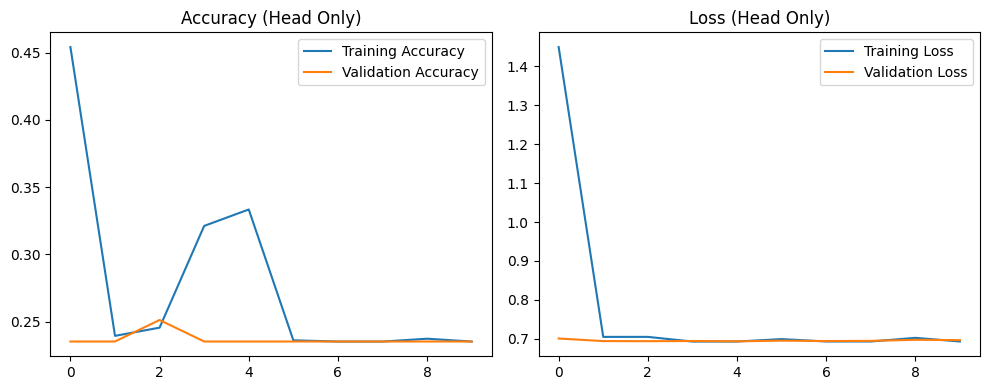


[INFO] Fine-tuning the last 30 layers of ResNet50 with class weighting...
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5165 - loss: 0.8383 - val_accuracy: 0.7648 - val_loss: 0.6154
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5204 - loss: 0.6861 - val_accuracy: 0.6651 - val_loss: 0.6586
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5439 - loss: 0.6882 - val_accuracy: 0.7676 - val_loss: 0.5794
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6463 - loss: 0.6632 - val_accuracy: 0.7780 - val_loss: 0.5250
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6017 - loss: 0.6555 - val_accuracy: 0.6990 - val_loss: 0.5905
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6476 - loss: 0.6261 - val_accuracy: 0.7752 - val_loss: 0.5270
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6227 - loss: 0.6630 - val_accuracy: 0.6256 - val_loss: 0.6424
Epoch 8/10
134/134 ━━━

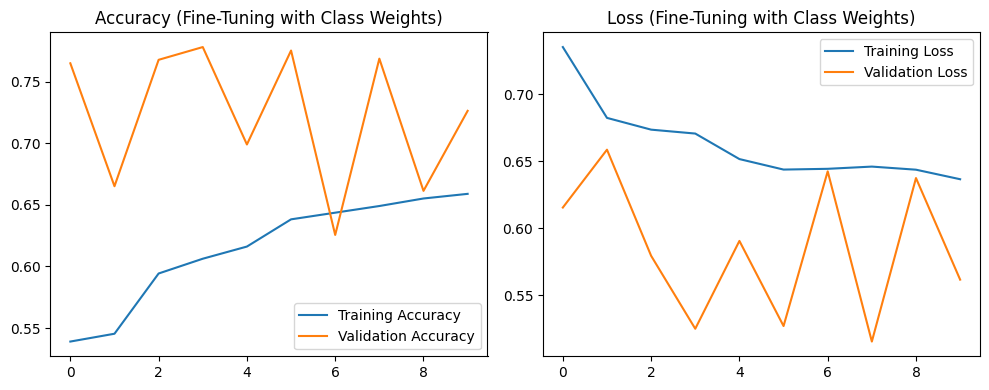


[INFO] Model saved to /content/drive/MyDrive/NIH_ChestXray/Pneumo_ResNet50_Best_model.keras


In [ ]:
# Training visualization
def plot_history(history, title_suffix=""):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Loss {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training functions
def train_head(model, train_gen, val_gen, class_weight):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print("\n[INFO] Training only the head of the model...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS_HEAD,
        validation_data=val_gen,
        class_weight=class_weight
    )
    return history

def fine_tune(model, base_model, train_gen, val_gen, class_weight):
    total_layers = len(base_model.layers)
    for layer in base_model.layers[total_layers - UNFROZEN_LAYERS:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_FINE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(f"\n[INFO] Fine-tuning the last {UNFROZEN_LAYERS} layers of ResNet50 with class weighting...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS_FINE,
        validation_data=val_gen,
        class_weight=class_weight
    )
    return history


# Main execution
def main():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    print("TensorFlow version:", tf.__version__)
    print("Available GPUs:", tf.config.list_physical_devices('GPU'))

    train_gen, val_gen, test_gen = create_data_generators()
    global model, base_model # Define model in global scope
    model, base_model = build_model()

    # Calculate class weights
    class_indices = train_gen.class_indices
    class_counts = {}
    total_train_samples = 0
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_indices[class_name]] = count
            total_train_samples += count

    total_classes = len(class_counts)
    class_weight = {}
    for cls_index, count in class_counts.items():
        weight = total_train_samples / (total_classes * count)
        class_weight[cls_index] = weight

    print("\nCalculated Class Weights:", class_weight)

    history_head = train_head(model, train_gen, val_gen, class_weight)
    plot_history(history_head, "(Head Only)")

    history_fine = fine_tune(model, base_model, train_gen, val_gen, class_weight)
    plot_history(history_fine, "(Fine-Tuning with Class Weights)")


    save_path = "/content/drive/MyDrive/NIH_ChestXray/Pneumo_ResNet50_Best_model.keras"
    model.save(save_path, save_format='tf')
    print(f"\n[INFO] Model saved to {save_path}")

if __name__ == "__main__":
    main()

### **Evaluation**

Found 1784 images belonging to 2 classes.
56/56 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.7898 - loss: 0.5088

Test Loss: 0.5666
Test Accuracy: 0.72534
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 642ms/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8133    0.7980    0.8056      1272
   pneumonia     0.5205    0.5449    0.5324       512

    accuracy                         0.7253      1784
   macro avg     0.6669    0.6714    0.6690      1784
weighted avg     0.7293    0.7253    0.7272      1784



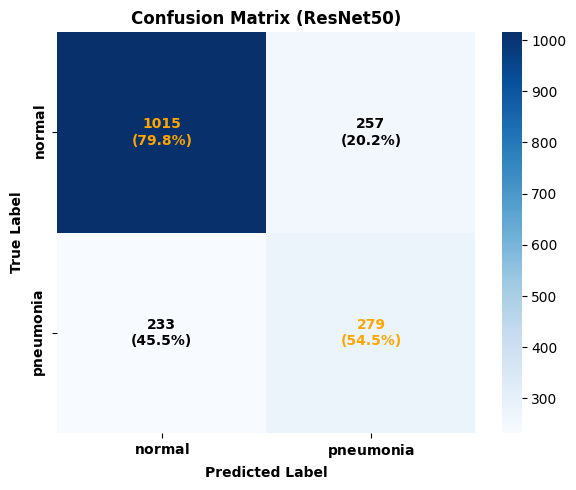

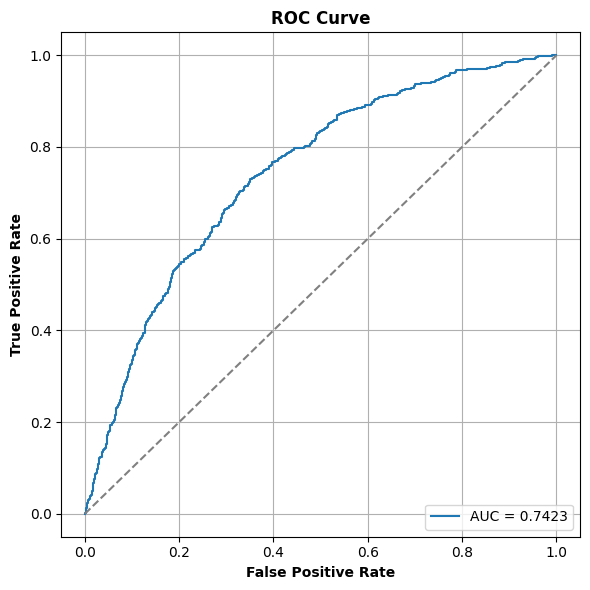


Model Size: 494.88 MB


In [ ]:
# Evaluate a trained ResNet50 model: classification report, AUROC, confusion matrix (with % annotations + bold labels)

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths
model_path = "/content/drive/MyDrive/NIH_ChestXray/Pneumo_ResNet50_Best_model.keras"
test_dir = "/content/drive/MyDrive/NIH_processed/test"

# Load the trained model from disk
model = load_model(model_path)

# Load test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.5f}")

# Get predictions
y_true = test_gen.classes
y_probs = model.predict(test_gen, verbose=1).ravel()
y_pred = (y_probs > 0.50).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4))

# Compute confusion matrix with counts + row-wise %
cm = confusion_matrix(y_true, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in test_gen.class_indices.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in test_gen.class_indices.keys()]
)

# Annotate with counts + percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold'
        )

plt.title("Confusion Matrix (ResNet50)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# Compute AUROC and plot ROC curve
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Get and print model size
model_size_bytes = os.path.getsize(model_path)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")

#### **Testing with other threshold (Optional)**

Found 1784 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 615ms/step - accuracy: 0.7898 - loss: 0.5088

Test Loss: 0.5666
Test Accuracy: 0.72534
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 642ms/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8323    0.7099    0.7662      1272
   pneumonia     0.4721    0.6445    0.5450       512

    accuracy                         0.6911      1784
   macro avg     0.6522    0.6772    0.6556      1784
weighted avg     0.7289    0.6911    0.7027      1784



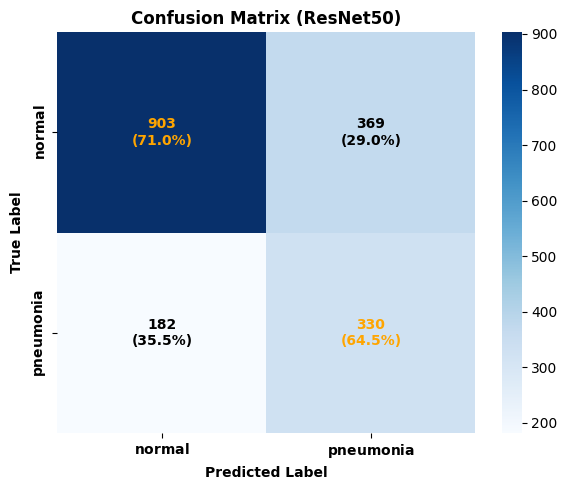

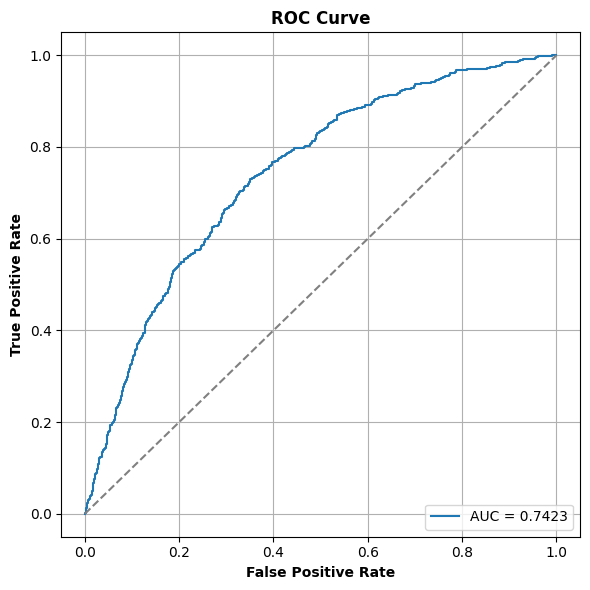


Model Size: 494.88 MB


In [ ]:
# Evaluate a trained ResNet50 model: classification report, AUROC, confusion matrix (with % annotations + bold labels)

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths
model_path = "/content/drive/MyDrive/NIH_ChestXray/Pneumo_ResNet50_Best_model.keras"
test_dir = "/content/drive/MyDrive/NIH_processed/test"

# Load the trained model from disk
model = load_model(model_path)

# Load test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.5f}")

# Get predictions
y_true = test_gen.classes
y_probs = model.predict(test_gen, verbose=1).ravel()
y_pred = (y_probs > 0.45).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4))

# Compute confusion matrix with counts + row-wise %
cm = confusion_matrix(y_true, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in test_gen.class_indices.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in test_gen.class_indices.keys()]
)

# Annotate with counts + percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold'
        )

plt.title("Confusion Matrix (ResNet50)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# Compute AUROC and plot ROC curve
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Get and print model size
model_size_bytes = os.path.getsize(model_path)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")